In [18]:
from argparse import ArgumentParser
from torch import nn
import torch
import math
import numpy as np
from sklearn.preprocessing import SplineTransformer
from collections import OrderedDict

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

##################################################################
#                       Data preprocessing                       #
##################################################################
def sim_data(n, dim, Type):
	if Type == 'A':
		X = torch.rand((n,2))
		y = torch.exp(2*torch.sin(X[:,0]*0.5*torch.pi)+ 0.5*torch.cos(X[:,1]*2.5*torch.pi))
		y = y.reshape(-1,1)
		y = y.float()
		
	elif Type == 'B':
		X = torch.rand((n, dim))
		y = 1
		for d in range(dim):
			a = (d+1)/2
			y *= ((torch.abs(4*X[:,d]-2)+a)/(1+a))
		y = y.reshape(-1,1)
		y = y.float()
	else:
		pass
	
	return X, y

def diag_mat_weights(dimp, type = 'first'):
	if type == 'first':
		dg = np.zeros((dimp-1, dimp))
		for i in range(dimp-1):
			dg[i,i] = -1
			dg[i,i+1]= 1
	elif type == 'second':
		dg = np.zeros((dimp-2, dimp))
		for i in range(dimp-2):
			dg[i,i] = -1
			dg[i,i+1]= 2
			dg[i,i+2]= -1
	else:
		pass
	return torch.Tensor(dg)

def num_para(model):
	tp = 0
	for param in model.parameters():
		tp += param.numel()
	return tp
    
##################################################################
#                          DPS Modeling                          #
##################################################################

class BSL(nn.Module):
    def __init__(self, degree, num_knots, num_neurons, bias = True):
        super(BSL, self).__init__()
        self.degree = degree
        self.num_knots = num_knots
        self.num_neurons = num_neurons
        self.control_p = nn.Parameter(torch.randn(self.num_knots, self.num_neurons))
        
        if bias:
            self.bias = nn.Parameter(torch.randn(self.num_neurons))
        else:
            self.register_parameter('bias', None)
            
        self.inter = {}
    
    def basis_function(self, x, i, k, t):
    
        # Base case: degree 0 spline
        if k == 0:
            return ((t[i] <= x) & (x < t[i + 1])).float()
    
        # Recursive case
        denom1 = t[i + k] - t[i]
        denom2 = t[i + k + 1] - t[i + 1]
    
        term1 = 0
        if denom1 != 0:
            term1 = (x - t[i]) / denom1 * self.basis_function(x, i, k - 1, t)
    
        term2 = 0
        if denom2 != 0:
            term2 = (t[i + k + 1] - x) / denom2 * self.basis_function(x, i + 1, k - 1, t)
    
        return term1 + term2

    def knots_distribution(self, dg, nk):

        knots = torch.cat([torch.linspace(-0.002, -0.001, steps=dg),            # Add repeated values at the start for clamping
            torch.linspace(0, 1, nk-2*dg-2),  # Uniform knot spacing in the middle
            torch.linspace(1.001, 1.002, steps=dg)           # Add repeated values at the end for clamping
            ]).view(-1,1)
     
        return knots
    
    def basis_function2(self, x, spl):
        basis_output = spl.fit_transform(x.cpu().numpy())
        return basis_output
            
    def forward(self, x):
        batch_size, num_features = x.size()
        device = x.device
        
        # Create knot vector and apply B-spline basis functions for each feature
    
        basises = []
        knots = self.knots_distribution(self.degree, self.num_knots)
        #knots = knots.to(device)
        spl = SplineTransformer(n_knots=self.num_knots, degree=self.degree, knots = knots)

        
        for feature in range(num_features):
            # Calculate B-spline basis functions for this feature
            
            basis = self.basis_function2(x[:, feature].reshape(-1,1), spl)
            basis = torch.Tensor(basis).to(device)
            basises.append(basis)
        
        self.inter['basic'] = torch.reshape(torch.stack(basises, dim = 1), (batch_size, self.num_knots * self.num_neurons)).T
        basises = torch.stack(basises)
        tout = basises.permute(1,2,0) * self.control_p
        tout = tout.sum(dim =1)
        if self.bias is not None:
            tout += self.bias        
            
        return tout


class NormLayer(nn.Module):
    def __init__(self):
        super(NormLayer, self).__init__()

    def forward(self, x):
        min_val = torch.min(x, axis = 1).values.reshape(-1,1)
        max_val = torch.max(x, axis = 1).values.reshape(-1,1)

        x = (x - min_val)/(max_val - min_val)  # Rescale to [0, 1]
        return x.detach()
        
class BSpline_block(nn.Module):
    def __init__(self, degree, num_knots, num_neurons, dropout = 0.0, bias = True):
        super(BSpline_block, self).__init__()

        self.block = nn.Sequential(OrderedDict([
            ('norm', NormLayer()),
            ('BSL', BSL(degree = degree, num_knots = num_knots, num_neurons = num_neurons, bias = bias)),
            ('drop', nn.Dropout(dropout)),
        ]))
        
    def forward(self, x):
        return self.block(x)
        
class StackBS_block(nn.Module):
    def __init__(self, block, degree, num_knots, num_neurons, num_blocks, dropout = 0.0, bias = True):
        super().__init__()
        self.model = nn.ModuleDict({
            f'block_{i}': block(degree = degree, num_knots = num_knots, num_neurons = num_neurons)
            for i in range(num_blocks)
        })

    def forward(self, x):
        for name, block in self.model.items():
            x = block(x)
        return x


class DPS(nn.Module):
    def __init__(self, input_dim, degree, num_knots, num_neurons, num_bsl, dropout, output_dim, bias):
        super(DPS, self).__init__()
        self.num_neurons = num_neurons
        self.num_knots = num_knots
        self.ln1 = nn.Linear(input_dim, num_neurons)
        self.Spline_block = StackBS_block(BSpline_block, degree = degree, num_knots = num_knots, num_neurons = num_neurons, num_blocks = num_bsl, dropout = dropout)
        self.ln2 = nn.Linear(num_neurons, output_dim)
        
    def forward(self, x):
        
        x = self.ln1(x)
        spout = self.Spline_block(x)
        output = self.ln2(spout)
        
        return output

    def get_para_ecm(self, x):

        '''
        ecm_para: A dictionary that collects the parameter we need to the following ECM algorithm.
        ecm_para.basic: Store the output of each B-Spline block; Dimension = [n_sample, n_neurons]
        ecm_para.ebasic Store the weight matrix of each B-Spline expansion; Dimension = [n_knots * n_neurons, n_sample]

        '''
        ecm_para = {}
        bs_block_out = {}
        bs_spline_weight = {}
        bs_spline_value = {}
        bs_spline_bias = {}

        _ = self(x)
        
        def get_activation(name):
            def hook(model, input, output):
                bs_block_out[name] = output.detach()
            return hook

        handles = []
        for name, layer in self.named_modules():
            if 'block.drop' in name:
                handles.append(layer.register_forward_hook(get_activation(name)))
            elif 'block.BSL' in name:
                bs_spline_value[name] = layer.inter['basic'].detach()
                bs_spline_weight[name] = layer.control_p.detach()
                bs_spline_bias[name] = layer.bias.detach()
        # Run forward pass (triggers hooks)
        _ = self(x)

        # Clean up hooks
        for h in handles:
            h.remove()
            
        ecm_para['basic'] = torch.stack(list(bs_block_out.values()), dim=0)
        ecm_para['ebasic'] = torch.stack(list(bs_spline_value.values()), dim=0)
        ecm_para['wbasic'] = torch.stack(list(bs_spline_weight.values()), dim=0)
        ecm_para['bbasic'] = torch.stack(list(bs_spline_bias.values()), dim=0)
        del bs_block_out, bs_spline_weight, bs_spline_value, bs_spline_bias, _
        torch.cuda.empty_cache()
        
        return ecm_para

    def fit(self, x):
        return 0

class EarlyStopping:
    def __init__(self, patience=5, verbose=False, delta=0, path='checkpoint.pt'):

        self.patience = patience
        self.verbose = verbose
        self.counter = 0
        self.best_score = None
        self.early_stop = False
        self.val_loss_min = np.inf
        self.delta = delta
        self.path = path

    def __call__(self, val_loss, model):
        score = -val_loss  # because we want to minimize val_loss

        if self.best_score is None:
            self.best_score = score
            self.save_checkpoint(val_loss, model)
        elif score < self.best_score + self.delta:
            self.counter += 1
            if self.verbose:
                print(f'EarlyStopping counter: {self.counter} out of {self.patience}')
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_score = score
            self.save_checkpoint(val_loss, model)
            self.counter = 0

    def save_checkpoint(self, val_loss, model):
        '''Saves model when validation loss decreases.'''
        if self.verbose:
            print(f'Validation loss decreased ({self.val_loss_min:.6f} --> {val_loss:.6f}). Saving model ...')
        torch.save(model.state_dict(), self.path)
        self.val_loss_min = val_loss
        
def train_one_epoch(model, x, y, criterion, optimizer, device):
    model.train()
    total_loss = 0.0
    x, y = x.to(device), y.to(device)

    optimizer.zero_grad()
    outputs = model(x)
    loss = criterion(outputs, y)
    loss.backward()
    optimizer.step()

    return loss

                
def validate(model, x, y, criterion, device):
    model.eval()
    total_loss = 0.0
    x, y = x.to(device), y.to(device)
    outputs = model(x)
    loss = criterion(outputs, y)

    return loss
    
##################################################################
#                          ECM Iteration                         #
##################################################################

def ECM(par, initial_xi = 1, initial_sigma = 1, initial_lambda = 1e-4):
    lambdab = initial_lambda
    sigma = initial_sigma
    xi = initial_xi
    
    n_block, num_knots, num_neurons = par['wbasic'].size()
    ls_lambda = torch.empty(n_block)
    
    for l in range(n_block):
        B = par['ebasic'][l]
        By = par['basic'][l]
        WB = par['wbasic'][l]
        
        DB = diag_mat_weights(WB.size()[0]).to(device)
        size = B.size()[1]
        S = DB.T @ DB
        Cov_a = (xi**2)* torch.linalg.pinv(S)
        Cov_a.to(device)
        Cov_e = (torch.eye(size*num_neurons)* sigma).to(device)
        
        block_y = torch.reshape(By, (-1,1))
        flatB = B.view(num_neurons, num_knots, size)
            
        sqr_xi= 0
        sqr_sig = 0

        for i in range(num_neurons):
            Ncov = (Cov_a -(Cov_a @ flatB[i]) @ (torch.linalg.pinv(flatB[i].T @ Cov_a @ flatB[i] + Cov_e[size*i:size*(i+1),size*i:size*(i+1)]) @ flatB[i].T @ Cov_a))
            Nmu = (Cov_a @ flatB[i]) @ (torch.linalg.pinv(flatB[i].T @ Cov_a @ flatB[i] + Cov_e[size*i:size*(i+1),size*i:size*(i+1)])) @ By[:,i].reshape(-1,1)
            
            first_xi = S @ Ncov
            second_xi = (Nmu.T @ S @ Nmu)
            sqr_xi += torch.trace(first_xi) + second_xi
                
            first_sig = torch.norm(By[:,i])
            second_sig = 2 * (By[:,i] @ flatB[i].T) @ Nmu 
            third_sig = torch.trace((flatB[i] @ flatB[i].T) @ Ncov)
            four_sig = (Nmu.T @ flatB[i] @ flatB[i].T @ Nmu)
            
            sqr_sig += (first_sig + second_sig + third_sig + four_sig)
            
            del first_xi, second_xi, first_sig, second_sig, third_sig, four_sig
            torch.cuda.empty_cache()
            
        sqr_xi /= num_neurons
        sqr_sig /= (num_neurons*size)

        ls_lambda[l] = (sqr_sig/sqr_xi).item()
        del Cov_a, Cov_e, flatB
        torch.cuda.empty_cache()
        
    return sqr_sig, sqr_xi, ls_lambda
    
def ECM_layersise_update(model, par, Lambda, x, y):

    model.eval()
    device = x.device
    
    B_out, B_in, B_w, B_b = par['basic'], par['ebasic'], par['wbasic'], par['bbasic']
    n_layer, nk, nm = B_w.size()
    DB = diag_mat_weights(B_w[0].size()[0], 'second').to(device)

    Project_matrix = (torch.linalg.pinv(B_in[-1].T @ B_in[-1]) @ B_in[-1].T @ B_in[-1])
    Size = [b.size()[1] for b in B_in]

    B_in = B_in.view(n_layer, nm, nk, Size[0])

    for l in range(n_layer):    
        NW = torch.empty((nk, nm)).to(device)
        NB = torch.empty((nm)).to(device)
        
        for i in range(nm):
            B1y = B_out[l][:,i] - B_b[l][i]
            BB = B_in[l][i].T
    
            # Update the weights and bias
            NW[:, i] = (torch.inverse(BB.T @ BB + (Lambda[l]/Size[l]) * (DB.T @ DB)) @ BB.T @ B1y)
            NB[i] = torch.mean(B_out[l][:,i] - (NW[:,i] @ BB.T))
                
        # update the weight
        block = getattr(model.Spline_block.model, f'block_{l}')
        getattr(block.block.BSL, 'control_p').data = NW
        getattr(block.block.BSL, 'bias').data = NB

        del NW, NB, B1y, BB, block
        torch.cuda.empty_cache()
        
    with torch.no_grad():
        DPSy = model(x)
        Update_Train_Loss = np.round(criterion(y, DPSy.detach()).item(), 5)
        GCV = np.round((torch.norm(y - DPSy)/(Size[-1]-torch.trace(Project_matrix))).item(), 5)
    
    return model, GCV
    
def ECM_update(model, max_iter, x, y, tor = 1e-6, echo = False):
    Best_lld = torch.inf
    patient = 10
    pcount = 0

    # Before Update
    ECM_para = model.get_para_ecm(x)
    prelld = likelihood(ECM_para, 1, 1)
    
    for i in range(max_iter):
        _ = model(x)
        ECM_para = model.get_para_ecm(x)
        # Layerwise Update
        ECM_sig, ECM_xi, ECM_Lambda = ECM(ECM_para, initial_xi = 1, initial_sigma = 1, initial_lambda = 1e-4)
        model, GCV = ECM_layersise_update(model, ECM_para, ECM_Lambda, x, y)

        # Post-likelihood
        update_ECM_para = model.get_para_ecm(x)
        postlld = likelihood(ECM_para, ECM_sig, ECM_xi)

        relative_lld = torch.abs(prelld - postlld)/ torch.abs(prelld)
        if echo:
            print('Current relative likelihood: ', relative_lld)

        if torch.abs(relative_lld) < tor:
            Iter = i+1
            print('Likelihood Converge at ', i+1,' iteration')
            break
            
        if relative_lld < Best_lld:
            BestLambda = ECM_Lambda
            BestGCV = GCV
            pcount = 0
        else:
            pcount += 1

        if pcount == patient:
            Iter = i+1
            print('Likelihood Converge at ',i,' iteration')
            break

        prelld = postlld
        Iter = i+1
        
        del ECM_para, ECM_Lambda
    
    return BestLambda, Iter

def likelihood(parameter, sigmasq, xisq):

    B_out, B_in, B_w, B_b = parameter['basic'], parameter['ebasic'], parameter['wbasic'], parameter['bbasic']

    n = B_in.size()[2]
    nl, nk, nm = B_w.size()
    llk = 0
    for l in range(nl):
        for i in range(nm):
            hidden_nm = B_in[l, nk*i:nk*(i+1)]
            D = diag_mat_weights(hidden_nm.size()[0]).to(device)
            next_hidden_nm = B_out[l, :, i]

            estimate_y = hidden_nm.T @ torch.pinverse(hidden_nm @ hidden_nm.T) @ hidden_nm @ next_hidden_nm

            llk += (-torch.norm(next_hidden_nm - estimate_y)/(2 * sigmasq))
            llk += (-torch.norm(hidden_nm.T @ (D.T @ D) @ hidden_nm)/(2*xisq))
            llk += (-n/2)*torch.log(2*torch.pi*torch.as_tensor(sigmasq))
            
        llk += (-nm**2/2)*torch.log(torch.norm(torch.pinverse(D.T @ D))*torch.as_tensor(xisq))

    return llk

In [52]:
neuron_list = [50]
knot_list = [20]

X_train = data[str(d+1)]['TrainX']; X_test = data[str(d+1)]['TestX']; X_val = data[str(d+1)]['ValX']
y_train = data[str(d+1)]['Trainy']; y_test = data[str(d+1)]['Testy']; y_val = data[str(d+1)]['Valy']

with torch.no_grad():
    model = DPS(input_dim = ndim, degree = 3, num_knots = knot_list[0], num_neurons = neuron_list[0], num_bsl = nl, dropout = 0.0, output_dim = Fout, bias = True).to(device)
    model.load_state_dict(torch.load("./best_DBS_model_d" + str(d+1)+'n'+str(neuron_list[0])+'k'+str(knot_list[0])+ ".pt", weights_only = True))
    ECM_para = model.get_para_ecm(X_train)

    B_out, B_in, B_w, B_b = ECM_para['basic'], ECM_para['ebasic'], ECM_para['wbasic'], ECM_para['bbasic']
    prelld = likelihood(ECM_para, 1, 1)

## DS training

In [2]:
ntrain = 800
ntest = 400
Dtype = 'A'
ndim = 2
learning_rate = 1e-1
ndf = 10
nl = 1
nm = 50
nk = 20   

Fout = 1
nepoch = 10000
data = {}

device = torch.device('cpu')

for d in range(ndf):
    torch.manual_seed(d)

    X_train, y_train = sim_data(ntrain, ndim, Dtype)
    X_train, y_train = X_train.to(device), y_train.to(device) 
    X_val, y_val = sim_data(ntrain, ndim, Dtype)
    X_val, y_val = X_val.to(device), y_val.to(device) 
    X_test, y_test = sim_data(ntest, ndim, Dtype)
    X_test, y_test = X_test.to(device), y_test.to(device) 

    epstrain = torch.normal(0, torch.var(y_train)*0.01, size=y_train.size()).to(device)
    epstest = torch.normal(0, torch.var(y_test)*0.01, size=y_test.size()).to(device)
    epsval = torch.normal(0, torch.var(y_val)*0.01, size=y_val.size()).to(device) 

    y_train, y_val, y_test = y_train + epstrain, y_val + epsval, y_test + epstest
    data[str(d+1)] = {'TrainX': X_train, 'Trainy': y_train, 'ValX': X_val, 'Valy': y_val, 'TestX': X_test, 'Testy': y_test}

result = {}
Lambdalist = {}
Bres = np.zeros((ndf))
Pres = np.zeros((ndf))
Dres = np.zeros((ndf))
Iterlist = np.zeros((ndf))

criterion = nn.MSELoss()

In [5]:
neuron_list = [45, 50, 55, 60]
knot_list = [15, 20, 25]
Lambda_list = torch.zeros((len(neuron_list), len(knot_list)))
Lambdadict = {}
nl = 1

for d in range(ndf):
    print('dataset: ', str(d+1))
    X_train = data[str(d+1)]['TrainX']; X_test = data[str(d+1)]['TestX']; X_val = data[str(d+1)]['ValX']
    y_train = data[str(d+1)]['Trainy']; y_test = data[str(d+1)]['Testy']; y_val = data[str(d+1)]['Valy']
    

    for i in range(len(neuron_list)):
        for j in range(len(knot_list)):
            best_model_path = "./best_DBS_model_d" + str(d+1)+'n'+str(neuron_list[i])+'k'+str(knot_list[j])+ ".pt"
            early_stopping = EarlyStopping(patience=30, verbose=False, delta=1e-3, path= best_model_path)
    
            cand_model = DPS(input_dim = ndim, degree = 3, num_knots = knot_list[j], num_neurons = neuron_list[i], num_bsl = nl, dropout = 0.0, output_dim = Fout, bias = True).to(device)
            optimizer = torch.optim.Adam(cand_model.parameters(), lr=learning_rate)

            for epoch in range(nepoch):
                optimizer.zero_grad()
                cand_model.train()
        
                output = cand_model(X_train)
                loss = criterion(output, y_train)
                val_loss = validate(cand_model, X_val, y_val, criterion, device)
        
                if epoch % 50 == 0:
                    print(f"Epoch {epoch+1:02d} | Train Loss: {loss:.4f} | " f"Val Loss: {val_loss:.4f}")
        
                early_stopping(val_loss, cand_model)
                if early_stopping.early_stop:
                    print("Early stopping triggered. Restoring best model...")        
                    break
                loss.backward()
                optimizer.step()
        
            
            del cand_model, output, loss, val_loss

            
            ## ECM -> Find optimal Lambda
            with torch.no_grad():
                model = DPS(input_dim = ndim, degree = 3, num_knots = knot_list[j], num_neurons = neuron_list[i], num_bsl = nl, dropout = 0.0, output_dim = Fout, bias = True).to(device)
                model.load_state_dict(torch.load("./best_DBS_model_d" + str(d+1)+'n'+str(neuron_list[i])+'k'+str(knot_list[j])+ ".pt", weights_only = True))
                BMSPE = criterion(y_test, model(X_test).detach()).item()
                Bres[d] = BMSPE
                BestLambda, _ = ECM_update(model, 10, X_train, y_train, 1e-5, True)
                Lambda_list[i, j] = BestLambda
                
                del model 
            
            torch.cuda.empty_cache()
            
    Lambdadict[str(d+1)] = Lambda_list
    del X_train, y_train, X_test, y_test, X_val, y_val
    torch.cuda.empty_cache()

dataset:  1
Epoch 01 | Train Loss: 25.9218 | Val Loss: 23.2885
Epoch 51 | Train Loss: 0.8966 | Val Loss: 0.8646
Epoch 101 | Train Loss: 0.6622 | Val Loss: 0.6287
Epoch 151 | Train Loss: 0.5087 | Val Loss: 0.4843
Epoch 201 | Train Loss: 0.3204 | Val Loss: 0.3152
Epoch 251 | Train Loss: 0.2165 | Val Loss: 0.2264
Epoch 301 | Train Loss: 0.4004 | Val Loss: 0.4292
Epoch 351 | Train Loss: 0.1737 | Val Loss: 0.1855
Epoch 401 | Train Loss: 0.1610 | Val Loss: 0.1703
Epoch 451 | Train Loss: 0.1521 | Val Loss: 0.1599
Epoch 501 | Train Loss: 0.1496 | Val Loss: 0.1592
Epoch 551 | Train Loss: 0.1404 | Val Loss: 0.1478
Epoch 601 | Train Loss: 0.1349 | Val Loss: 0.1417
Epoch 651 | Train Loss: 0.1322 | Val Loss: 0.1363
Epoch 701 | Train Loss: 0.1268 | Val Loss: 0.1345
Epoch 751 | Train Loss: 0.1217 | Val Loss: 0.1283
Epoch 801 | Train Loss: 0.1170 | Val Loss: 0.1235
Epoch 851 | Train Loss: 0.1993 | Val Loss: 0.2187
Epoch 901 | Train Loss: 0.1101 | Val Loss: 0.1180
Epoch 951 | Train Loss: 0.1048 | Val L

ValueError: negative dimensions are not allowed

## DPS Training

In [ ]:
for d in range(ndf):
    print('dataset: ', str(d+1))
    X_train = data[str(d+1)]['TrainX']; X_test = data[str(d+1)]['TestX']; X_val = data[str(d+1)]['ValX']
    y_train = data[str(d+1)]['Trainy']; y_test = data[str(d+1)]['Testy']; y_val = data[str(d+1)]['Valy']
    

    for i in range(len(neuron_list)):
        for j in range(len(knot_list)):
            best_model_path = "./best_DPS_model_d" + str(d+1)+'n'+str(neuron_list[i])+'k'+str(knot_list[j])+ ".pt"
            early_stopping = EarlyStopping(patience=30, verbose=False, delta=1e-4, path= best_model_path)
    
            cand_model = DPS(input_dim = ndim, degree = 3, num_knots = knot_list[j], num_neurons = neuron_list[i], num_bsl = nl, dropout = 0.0, output_dim = Fout, bias = True).to(device)
            cand_model.load_state_dict(torch.load("./best_DBS_model_d" + str(d+1)+'n'+str(neuron_list[i])+'k'+str(knot_list[j])+ ".pt", weights_only = True))
            optimizer = torch.optim.Adam(cand_model.parameters(), lr=5e-3)

            for epoch in range(nepoch):
                optimizer.zero_grad()
                cand_model.train()
        
                output = cand_model(X_train)
                loss = criterion(output, y_train)
    
                for l in range(nl):
                    block = getattr(cand_model.Spline_block.model, f'block_{l}')
                    W = getattr(block.block.BSL, 'control_p')
                    loss +=  Lambdadict[str(d+1)][i, j]/X_train.size()[0] * torch.norm(diag_mat_weights(W.size()[0]).to(device) @ W)
        
                val_loss = validate(cand_model, X_val, y_val, criterion, device)
        
                if epoch % 10 == 0:
                    print(f"Epoch {epoch+1:02d} | Train Loss: {loss:.4f} | " f"Val Loss: {val_loss:.4f}")
        
                early_stopping(val_loss, cand_model)
                if early_stopping.early_stop:
                    print("Early stopping triggered. Restoring best model...")        
                    break
                loss.backward()
                optimizer.step()
        
            
            del cand_model, output, loss, val_loss
    
            ## ECM -> Find optimal Lambda
            with torch.no_grad():
                model = DPS(input_dim = ndim, degree = 3, num_knots = knot_list[j], num_neurons = neuron_list[i], num_bsl = nl, dropout = 0.0, output_dim = Fout, bias = True).to(device)
                model.load_state_dict(torch.load("./best_DPS_model_d" + str(d+1)+'n'+str(neuron_list[i])+'k'+str(knot_list[j])+ ".pt", weights_only = True))
                BMSPE = criterion(y_test, model(X_test).detach()).item()
                Pres[d] = BMSPE
                
                del model 
            torch.cuda.empty_cache()
            
    del X_train, y_train, X_test, y_test, X_val, y_val
    torch.cuda.empty_cache()

## Evaluation for MSELoss for DS and DPS

In [9]:
neuron_list = [45, 50, 55]
knot_list = [15, 20, 25]
ndf = 1

BList = torch.zeros((len(neuron_list), len(knot_list)))
PList = torch.zeros((len(neuron_list), len(knot_list)))

with torch.no_grad():
    for d in range(ndf):
        X_train = data[str(d+1)]['TrainX']; X_test = data[str(d+1)]['TestX']; X_val = data[str(d+1)]['ValX']
        y_train = data[str(d+1)]['Trainy']; y_test = data[str(d+1)]['Testy']; y_val = data[str(d+1)]['Valy']
    
        for i in range(len(neuron_list)):
            for j in range(len(knot_list)):
                model_DBS = DPS(input_dim = ndim, degree = 3, num_knots = knot_list[j], num_neurons = neuron_list[i], num_bsl = nl, dropout = 0.0, output_dim = Fout, bias = True).to(device)
                model_DBS.load_state_dict(torch.load("./best_DBS_model_d" + str(d+1)+'n'+str(neuron_list[i])+'k'+str(knot_list[j])+ ".pt", weights_only = True))
                model_DPS = DPS(input_dim = ndim, degree = 3, num_knots = knot_list[j], num_neurons = neuron_list[i], num_bsl = nl, dropout = 0.0, output_dim = Fout, bias = True).to(device)
                model_DPS.load_state_dict(torch.load("./best_DPS_model_d" + str(d+1)+'n'+str(neuron_list[i])+'k'+str(knot_list[j])+ ".pt", weights_only = True))
                BList[i, j] = criterion(y_test, model_DBS(X_test).detach()).item()
                PList[i, j] = criterion(y_test, model_DPS(X_test).detach()).item()

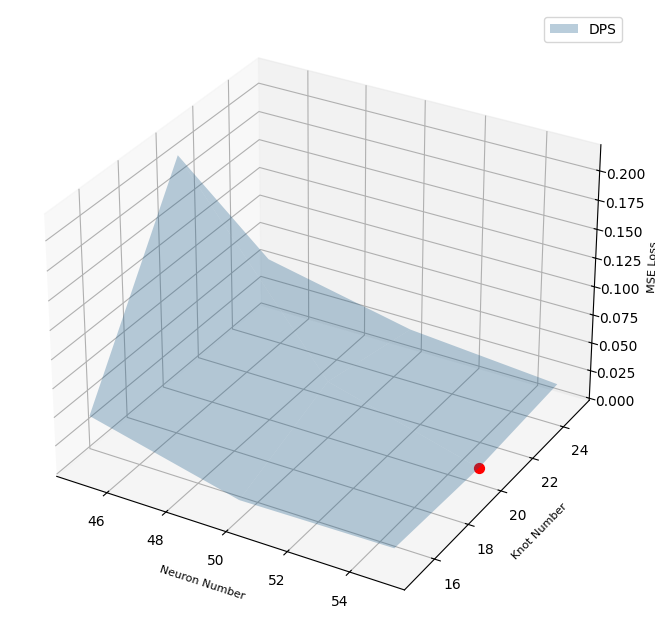

In [28]:
import matplotlib.pyplot as plt
import numpy as np
from mpl_toolkits.mplot3d import Axes3D

fig = plt.figure(figsize=(6.69, 6.69))  # Two-column width [2][6]
fig.subplots_adjust(hspace=0.4, wspace=0.4)

ax = fig.add_subplot(1, 1, 1, projection='3d')
    
X, Y = np.meshgrid(neuron_list, knot_list)
Z1 = BList.detach().numpy()
Z2 = PList.detach().numpy()

# Plot surfaces with JASA-compliant formatting
#surf1 = ax.plot_surface(X, Y, Z1, cmap='viridis', alpha=0.3, 
#                     linewidth=0.5, antialiased=True, label='DS')

surf2 = ax.plot_surface(X, Y, Z2, alpha=0.3, 
                       linewidth=0.5, antialiased=True, label='DPS')

ax.scatter(X[1,2], Y[1,2], Z2[1,2], color='red', s=50, marker='o') # 'o' for circle marker

ax.set_xlabel('Neuron Number', fontsize=8, labelpad=5)
ax.set_ylabel('Knot Number', fontsize=8, labelpad=5)
ax.set_zlabel('MSE Loss', fontsize=8, labelpad=5)

ax.legend()
fig.savefig('Sensitivity.png')
plt.tight_layout()

## ECM Converge

In [21]:
neuron_list = [45]; knot_list = [15]; max_iter = 10; Iter_list = torch.zeros(ndf); tor = 3e-6

for d in range(ndf):
    X_train = data[str(d+1)]['TrainX']; y_train = data[str(d+1)]['Trainy']
    
    with torch.no_grad():
        model = DPS(input_dim = ndim, degree = 3, num_knots = knot_list[0], num_neurons = neuron_list[0], num_bsl = nl, dropout = 0.0, output_dim = Fout, bias = True).to(device)
        model.load_state_dict(torch.load("./best_DBS_model_d" + str(d+1)+'n'+str(neuron_list[0])+'k'+str(knot_list[0])+ ".pt", weights_only = True))
    
        BestLambda, Iter_list[d] = ECM_update(model, max_iter, X_train, y_train, tor, echo = True)

    del X_train, y_train
    torch.cuda.empty_cache()

Current relative likelihood:  tensor([[0.0834]])
Current relative likelihood:  tensor([[5.5847e-06]])
Current relative likelihood:  tensor([[6.2053e-06]])
Current relative likelihood:  tensor([[5.2125e-06]])
Current relative likelihood:  tensor([[5.8330e-06]])
Current relative likelihood:  tensor([[5.7090e-06]])
Current relative likelihood:  tensor([[5.2126e-06]])
Current relative likelihood:  tensor([[6.2055e-06]])
Current relative likelihood:  tensor([[5.2126e-06]])
Current relative likelihood:  tensor([[5.8953e-06]])


FileNotFoundError: [Errno 2] No such file or directory: './best_DBS_model_d2n45k15.pt'

In [6]:
            BestLambda, _ = ECM_update(model, 10, X_train, y_train, 1e-5, True)


0